In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [3]:
df=pd.read_csv("./processed_df.csv")
df=df.drop(columns=["Unnamed: 0"])

### We can see visually, that acceptances only really start to trickle in past about 675 GMAT and 3.2 GPA

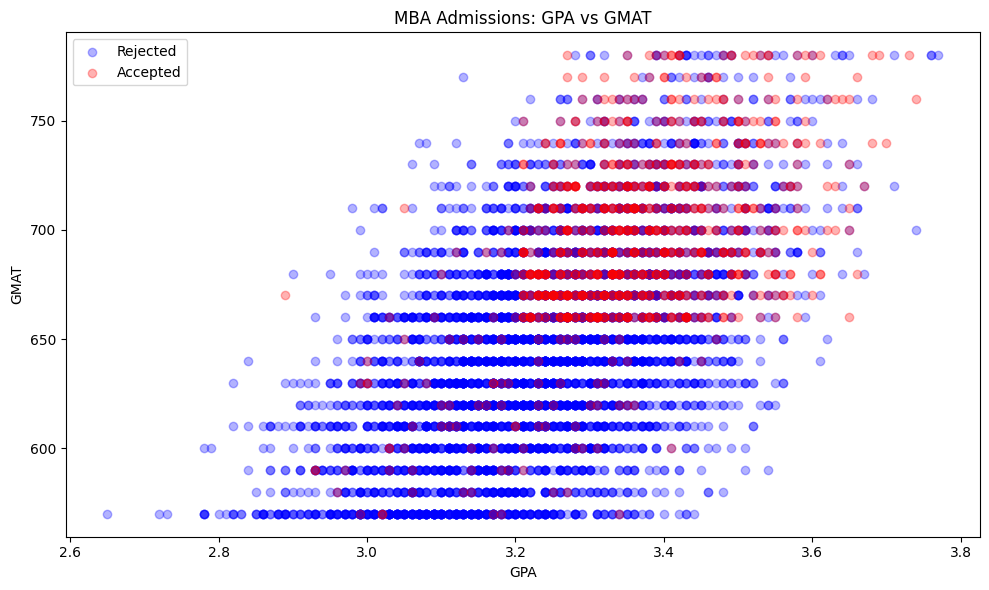

In [4]:
plt.figure(figsize=(10, 6))

# Create scatter plot with two colors
plt.scatter(df[df['accepted']==0]['gpa'], df[df['accepted']==0]['gmat'], 
          c='blue', label='Rejected', alpha=0.3)
plt.scatter(df[df['accepted']==1]['gpa'], df[df['accepted']==1]['gmat'], 
          c='red', label='Accepted', alpha=0.3)

# Add labels and title
plt.xlabel('GPA')
plt.ylabel('GMAT')
plt.title('MBA Admissions: GPA vs GMAT')
plt.legend()
plt.tight_layout()
plt.show()

####  Before clustering our data, we first need to figure out the optimal number of clusters to select. We will use the elbow method for this- it appears k=4 is optimal.

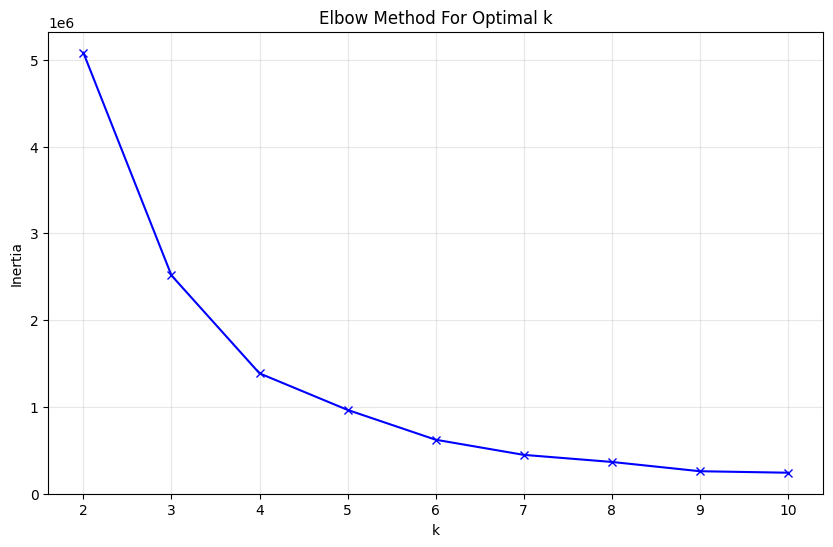

In [5]:
inertias = []
K = range(2, 11)
for k in K:
   kmeans = KMeans(n_clusters=k, random_state=42,init="k-means++")
   kmeans.fit(df.drop(columns="accepted"))
   inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True, alpha=0.3)
plt.show()

### We now need to cluster our data using k=4. Then for each cluster we will go through all points and choose the 10 closest points(KNN) and compute the % of points(out of those 10) that share the same label and then take the mean across the points.

In [6]:
kmeans = KMeans(n_clusters=4, random_state=42,init="k-means++")
kmeans.fit(df.drop(columns="accepted"))

KMeans(n_clusters=4, random_state=42)

In [16]:
cluster_labels = kmeans.labels_
np_df = df.to_numpy() 
cluster_purity_dict = {cluster:[] for cluster in np.unique(cluster_labels)}

for i in range(len(cluster_labels)):  # For each point
    cluster_label = cluster_labels[i]
    # Filter points with the same cluster label
    filtered_df = df[cluster_labels == cluster_label].reset_index(drop=True)
    np_filtered_df = filtered_df.to_numpy()
    
    # Get point's label (accepted/rejected)
    point_label = df['accepted'].iloc[i]
    
    # Find nearest neighbors within same cluster
    nearest_neighbors_index = np.linalg.norm(np_df[i].reshape(1, -1) - np_filtered_df, axis=1).argsort()[1:11]
    nearest_neighbors_labels = filtered_df['accepted'].iloc[nearest_neighbors_index].values
    
    # Calculate purity (proportion of neighbors with same acceptance status)
    point_purity = np.mean(nearest_neighbors_labels == point_label)
    cluster_purity_dict[cluster_label].append(point_purity)

# Calculate average purity for each cluster
cluster_purity_dict_avg = {cluster:np.mean(cluster_purity_dict[cluster]) 
                          for cluster in np.unique(cluster_labels)}


In [17]:
cluster_purity_dict_avg

{0: 0.9718082581869958,
 1: 0.7226457399103139,
 2: 0.9701579384871155,
 3: 0.8076109936575053}

##### We notice that clusters 0 and 2 have very high purity, while the 1st and 3rd have lower. Let us explore.

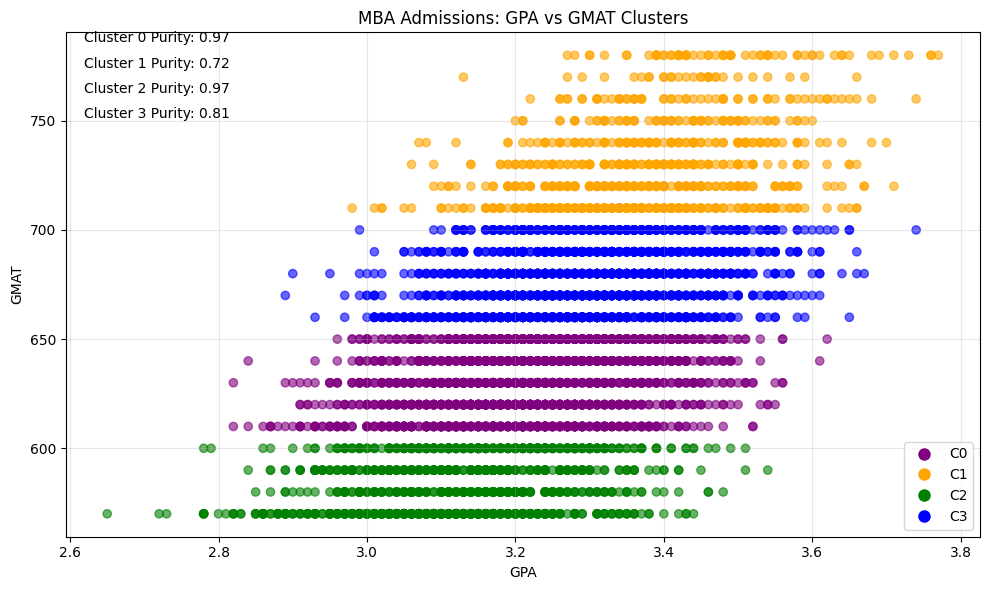

In [18]:
# I used chatgpt for plotting code

plt.figure(figsize=(10, 6))

# Define discrete colors for each cluster
colors = ['purple', 'orange', 'green', 'blue']  # or any 4 colors you prefer

# Create scatter plot with discrete colors
scatter = plt.scatter(df['gpa'], df['gmat'], 
                     c=[colors[i] for i in cluster_labels],    
                     alpha=0.6)

plt.xlabel('GPA')
plt.ylabel('GMAT')
plt.title('MBA Admissions: GPA vs GMAT Clusters')

# Create custom legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor=colors[i], label=f'C{i}', 
                            markersize=10) 
                  for i in range(4)]
plt.legend(handles=legend_elements)

# Add purity scores as text
for cluster in range(4):
    plt.text(0.02, 0.98 - cluster*0.05, 
             f'Cluster {cluster} Purity: {cluster_purity_dict_avg[cluster]:.2f}',
             transform=plt.gca().transAxes)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

##### We hypothesize the following: MBA programs are well known for prioritizing class diversity in their admissions decisions. There is also a common perception that candidates with elite academic credentials often have similar backgrounds and profiles. Our analysis explores whether candidates who are strong students but below the elite tier show greater diversity in their observable, quantifiable characteristics. If true, this natural diversity might lead admissions officers to rely more heavily on these observable factors and less on subjective elements outside our dataset. Conversely, for the elite cluster, while candidates are more similar to their nearest neighbors, they show lower decision purity. This suggests that factors beyond our dataset - subjective elements like essays and personal statements - become crucial differentiators. Once candidates reach this elite tier, admissions officers likely place greater weight on "fit" and personal qualities to distinguish between otherwise similar excellent candidates. This implies that elite candidates should focus their efforts on recommendation letters and essays, as these become the key differentiating factors among a pool of academically similar applicants.This pattern emerges naturally from the greater diversity among strong-but-not-elite candidates, which provides sufficient basis for differentiation through observable characteristics alone. In contrast, the similarity among elite candidates necessitates deeper consideration of subjective factors to make admissions decisions.

#### We also see that the bottom tier of candidates has a high purity, likely because there is a strict GPA or GMAT threshold that they did not meet.

In [23]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(np_df)

# Recalculate cosine distances with scaled data
cluster_cosine_distances = {}
for cluster in np.unique(cluster_labels):
    # Get scaled points in this cluster
    cluster_points = scaled_data[cluster_labels == cluster]
    
    # Calculate all pairwise cosine distances in cluster
    distances = []
    for i in range(len(cluster_points)):
        for j in range(i+1, len(cluster_points)):
            similarity = np.dot(cluster_points[i], cluster_points[j]) / (
                np.linalg.norm(cluster_points[i]) * np.linalg.norm(cluster_points[j]))
            distance = 1 - similarity
            distances.append(distance)
    
    cluster_cosine_distances[cluster] = np.mean(distances)

In [24]:
cluster_cosine_distances

{0: 0.9826956278759611,
 1: 0.8638471753478781,
 2: 0.8929678354828648,
 3: 0.9804565949730331}